In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import scipy.stats as st

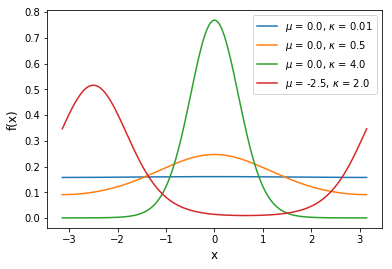

In [2]:
x = np.linspace(-np.pi, np.pi, 200)
mus = [0., 0., 0.,  -2.5]
kappas = [.01, 0.5,  4., 2.]
for mu, kappa in zip(mus, kappas):
    pdf = st.vonmises.pdf(x, kappa, loc=mu)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

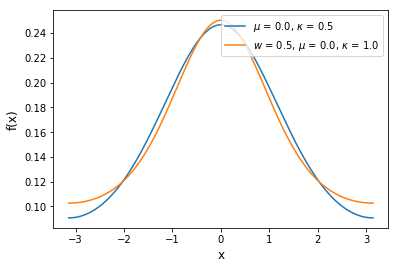

In [3]:
mu = 0.
kappa = 0.5
pdf = st.vonmises.pdf(x, kappa, loc=mu)
plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))

w = .5
mu = 0.
kappa = 1.
pdf = w*st.vonmises.pdf(x, kappa, loc=mu) + (1-w)*st.uniform.pdf(x, -np.pi, np.pi*2)
plt.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

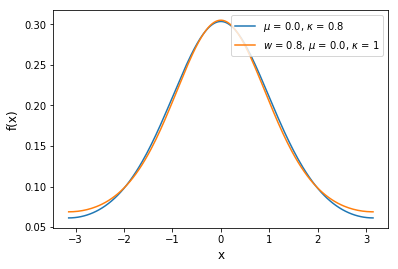

In [4]:
mu = 0.
kappa = .8
pdf = st.vonmises.pdf(x, kappa, loc=mu)
plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))

w = .8
mu = 0.
kappa = 1
pdf = w*st.vonmises.pdf(x, kappa, loc=mu) + (1-w)*st.uniform.pdf(x, -np.pi, np.pi*2)
plt.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

In [5]:
nsize = 200
w0 = .8
mu0 = 0.
kappa0 = 1
size1 = round(nsize*w)
size2 = nsize-size1
y = np.hstack([st.vonmises(kappa0, loc=mu0).rvs(size1), st.uniform(-np.pi, np.pi*2).rvs(size2)])

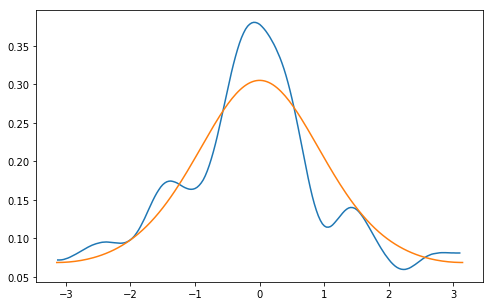

In [6]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
pm.kdeplot(y, ax=ax)
pdf = w*st.vonmises.pdf(x, kappa0, loc=mu0) + (1-w0) * st.uniform.pdf(x, -np.pi, np.pi*2)
ax.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa));

In [7]:
with pm.Model() as m1:
    mu = pm.Uniform('mu', -np.pi, np.pi)
    sd = pm.HalfFlat('sd')
    pm.VonMises('y', mu, kappa=sd, observed=y)
    tr1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1004.64draws/s]


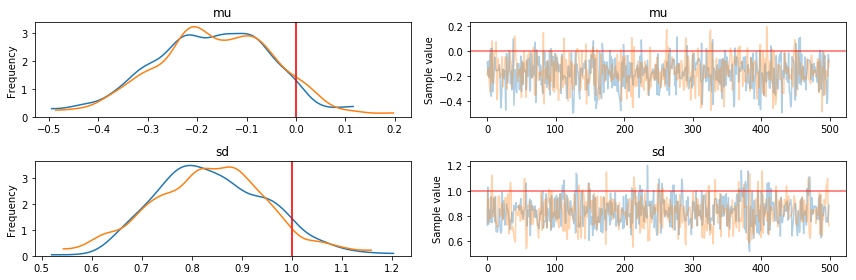

In [8]:
pm.traceplot(tr1, lines=dict(mu=mu0, sd=kappa0));

In [9]:
with pm.Model() as m2:
    mu = pm.Uniform('mu', -np.pi, np.pi)
    sd = pm.HalfFlat('sd')
    dist = [pm.Uniform.dist(-np.pi, np.pi),
            pm.VonMises.dist(mu, kappa=sd)]
    w = pm.Dirichlet('w', a=np.ones(2))
    pm.Mixture('y', w, dist, observed=y)
    tr2 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sd, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 488.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


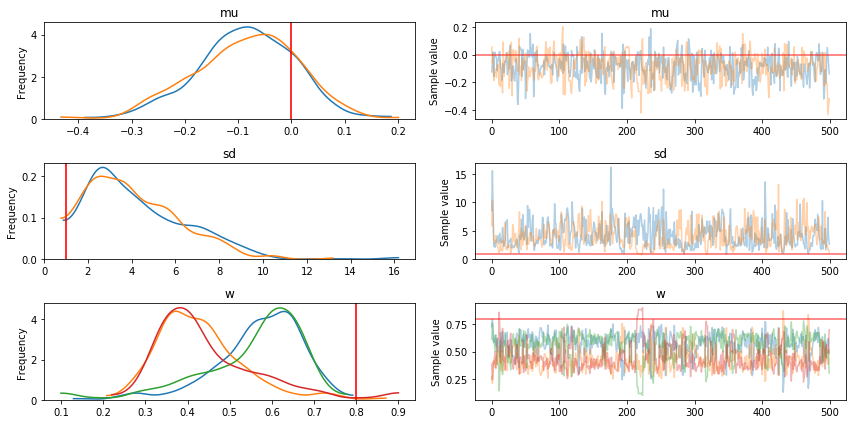

In [10]:
pm.traceplot(tr2, lines=dict(w=w0, mu=mu0, sd=kappa0));

In [12]:
pm.compare({m1:tr1, m2:tr2})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,674.45,3.94,0,0.6,16.04,0,0
0,676.81,1.94,2.36,0.4,15.64,7.02,0


In [36]:
import theano
complogp = m2.named_vars['y'].distribution._comp_logp(theano.shared(y))
f_complogp = m2.model.fastfn(complogp)
testpoint = m2.test_point
y_ = []
for i in range(tr2.nchains):
    tr = tr2._straces[i]
    for point in tr:
        d2 = dict((k,v) for k,v in point.items() if k in testpoint.keys())
        # get prediction
        y_.append(np.argmax(f_complogp(d2), axis=1))